In [8]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [9]:
import matplotlib.pyplot as plt
import torch
from sdm.models import S2Dataset

In [10]:
from torchvision.transforms import v2
img_transforms = v2.Compose([
    # Rotate
    v2.RandomRotation(30, expand=True),
    # Flip
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.2),
    # Affine
    v2.RandomAffine(10, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
    v2.Resize((304, 304), antialias=True),
])

In [11]:
dataset = S2Dataset(transforms=img_transforms)
n_input_bands = len(dataset.input_bands)

In [12]:
len(dataset)

2030

In [13]:
# import dataloader and split into train and validation
from sympy import Subs
from torch.utils.data import DataLoader, random_split, Subset


batch_size = 32
validation_split = .2
# Train on a subset - this is useful for experimenting and I will train on full dataset when I am happy with the model
#subset_size = 100
#dataset_subset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size])

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])



train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)

test_dataloader.dataset.dataset.transforms = None

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# set mac m1 device
device = torch.device('mps')

# Define the CNN model
# TODO: Add dropout
class SimpleCNN(nn.Module):
    """
    Vegetation Height Prediction CNN

    The model architectures uses a simple CNN with 3 convolutional layers and a gated skip connection.
    The gated skip connection is used to allow the model to use values from the original input to predict the output ina flexible way combining them with the higher dimensional features learned by the CNN.
    The logic behind this is that the CNN can focus on learning whether something is vegetation or not and the skip connection provides information from the canopy height model to help predict the vegetation height.

    Args:
        in_channels (int): Number of input channels (number of bands)
        tile_size (int): Size of the input tile. Defaults to 304.
    """
    def __init__(self, in_channels, tile_size=304, p_dropout=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # dropout
        self.dropout1 = nn.Dropout(p=p_dropout)  # Add dropout after first layer

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(p=p_dropout)  # Add dropout after second layer

        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # output 1 channel

        # Match the number of output channels with the input for skip connection
        self.match_dim = nn.Conv2d(in_channels, 1, kernel_size=1)  # 1x1 convolution
        
        # For the gating mechanism
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        original_x = x
        x = self.bn1(nn.functional.leaky_relu(self.conv1(x), negative_slope=0.01))
        x = self.dropout1(x)

        x = nn.functional.leaky_relu(self.conv2(x), negative_slope=0.01)
        x = self.dropout2(x)

        x = self.conv3(x)

        # Match the dimensions
        original_x_matched = self.match_dim(original_x)
        
        # Get the gating values from the original input
        gate_values = self.gate(original_x)
        
        x = x + gate_values * original_x_matched  # element-wise multiplication followed by addition

        return x.squeeze(1)



# Initialize the model, loss, and optimizer
model = SimpleCNN(n_input_bands)
criterion = nn.MSELoss()  # Mean Squared Error for regression task
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = model.to(device)
criterion = criterion.to(device)

loss_results = []

# Training loop
model.train()
n_epochs = 10  # Number of epochs
early_stop = 3  # Stop if the validation loss does not improve after 5 epochs
best_val_loss = 1e10  # Set initial best validation loss to infinity

for epoch in range(1, n_epochs + 1):
    epoch_loss = 0
    for i, (inputs, target, spatial_json) in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        target = target.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Epoch {epoch}/{n_epochs} Batch {i+1}/{len(train_dataloader)} Loss: {loss.item():.4f} RMSE: {loss.item()**0.5:.4f}")
    avg_loss_train = epoch_loss/len(train_dataloader)
    print(f"Epoch {epoch}/{n_epochs} Loss: {avg_loss_train} RMSE: {avg_loss_train**0.5:.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for i, (inputs, target, spatial_json) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            target = target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, target)
            epoch_loss += loss.item()
        avg_loss_val = epoch_loss/len(test_dataloader)
        
        print(f"Epoch {epoch}/{n_epochs} Validation Loss: {avg_loss_val} RMSE: {avg_loss_val**0.5:.4f}")
    
    loss_results.append({'train': avg_loss_train, 'val': avg_loss_val})

    scheduler.step()
    # Early stopping
    if avg_loss_val < best_val_loss:
        best_val_loss = avg_loss_val
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stop:
            print('Early stopping!')
            break

# Save the model
# torch.save(model.state_dict(), "simple_cnn_model.pth")


Epoch 1/1 Batch 1/3 Loss: 3.5711 RMSE: 1.8897
Epoch 1/1 Batch 2/3 Loss: 3.9553 RMSE: 1.9888
Epoch 1/1 Batch 3/3 Loss: 3.6306 RMSE: 1.9054
Epoch 1/1 Loss: 3.7190001805623374 RMSE: 1.9285
Epoch 1/1 Validation Loss: 16.201813220977783 RMSE: 4.0251


<Axes: >

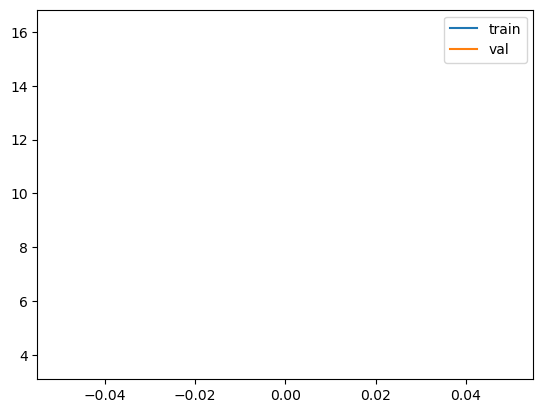

In [15]:
import pandas as pd
loss_df =  pd.DataFrame(loss_results)
loss_df.plot()

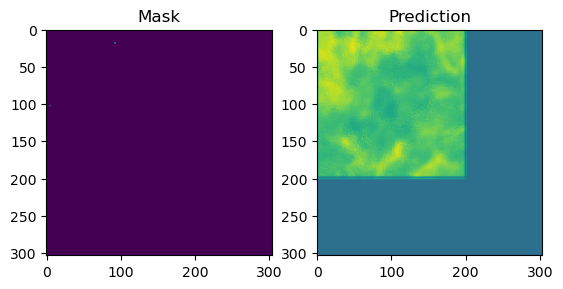

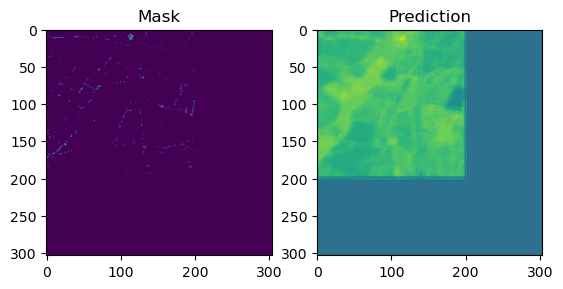

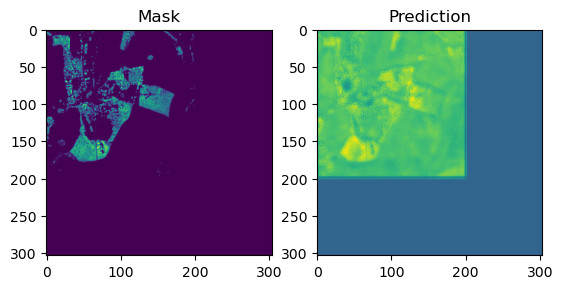

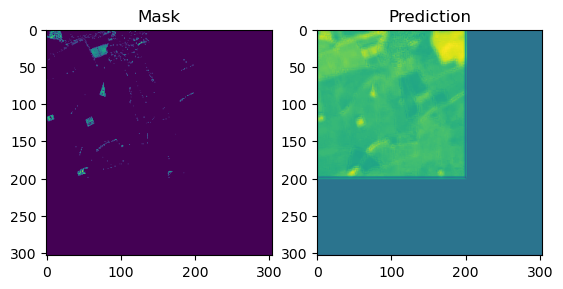

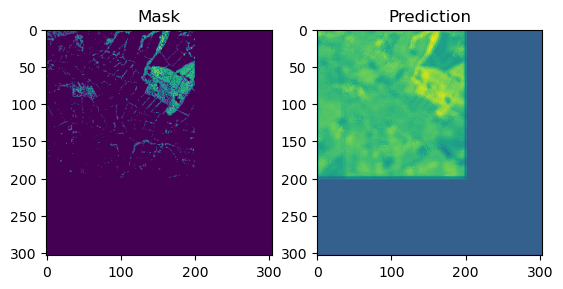

In [16]:
from sdm.models import SpatialTransformer, plot_predictions

model.eval()

# Make some predictions and plot the mask and the prediction in sub plots
results = []
with torch.no_grad():
    for i, (inputs, target, spatial_json) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        target = target.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, target)

        target_np = target.cpu().numpy()
        prediction_np = outputs.cpu().numpy()

        # iterate over the batch
        for i in range(len(target_np)):
            results.append({"target": target_np[i], "prediction": prediction_np[i], "transform": spatial_json[i]})
        

for i in range(5):
    plot_predictions(results[i]["target"], results[i]["prediction"])

In [21]:
import json

predictions = []
for result in results:
    transform_args  = json.loads(result["transform"])
    transformer = SpatialTransformer(**transform_args)
    prediction = transformer(result["prediction"])

    predictions.append(prediction)

    

In [22]:
predictions

[<xarray.DataArray (y: 200, x: 200)>
 array([[-0.11298396, -0.08123702, -0.0728206 , ..., -0.08157392,
         -0.08596271, -0.11119419],
        [-0.08338501, -0.0282035 , -0.00566173, ..., -0.01740856,
         -0.03234807, -0.06636311],
        [-0.062154  ,  0.00285086,  0.02666502, ...,  0.00848882,
         -0.00701736, -0.0581058 ],
        ...,
        [-0.06874041, -0.01513709,  0.00142987, ..., -0.00268239,
         -0.01646759, -0.05859555],
        [-0.07641347, -0.03475802, -0.0208299 , ..., -0.0209734 ,
         -0.02942331, -0.06844686],
        [-0.08310984, -0.05325513, -0.04850939, ..., -0.05343668,
         -0.06110243, -0.09073724]], dtype=float32)
 Coordinates:
   * x            (x) float64 3.938e+05 3.938e+05 ... 3.958e+05 3.958e+05
   * y            (y) float64 4.373e+05 4.373e+05 ... 4.353e+05 4.353e+05
     spatial_ref  int64 0
 Attributes:
     transform:  [10.0, 0.0, 393800.0, 0.0, -10.0, 437270.0, 0.0, 0.0, 1.0],
 <xarray.DataArray (y: 200, x: 200)>
 array(

In [17]:
# Save the model
#torch.save(model.state_dict(), "models/veg-height-cnn.pth")